# Classification Problem

In [1]:
%%capture
pip install torch==2.0.1+cu118 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0

In [8]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
import seaborn as sns
import textwrap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller

from numpy import array

#### load library for KNN DTW ####
import matplotlib.pyplot as plt
import os
import gc

import sys
import collections
import itertools
import statsmodels.api as sm
from scipy.stats import mode
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import f1_score, roc_curve

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve


from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.simplefilter('ignore')

import pickle

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf

import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import logging
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

device = "cuda" if torch.cuda.is_available() else "cpu"

from pytorch_forecasting.data.encoders import EncoderNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import base_metrics

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, accuracy_score
from pytorch_forecasting.metrics import MAE, MAPE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Q2a: EDA

In [7]:
file_name = 'QR_dataset/dataset2.csv'
df=pd.read_csv(file_name)

In [4]:
# How many missing data exist
missing_data=pd.DataFrame(df.isnull().sum().reset_index())
#missing_data=pd.DataFrame(df_train.isna().sum().reset_index())

missing_data.columns=["index","missingcount"]
missing_data=missing_data[missing_data["missingcount"]>0]
missing_data['missingper']=(missing_data['missingcount']/df.shape[0])*100


missing_data.set_index('index', inplace = True)
missing_data

,missingcount,missingper
index,,
target,1,0.147275


Since only the target column contain one missing data (0.147%), we simply drop that row

In [9]:
#drop nan row and convert date column to datetime format
df.dropna(inplace = True)
df['date'] = pd.to_datetime(df.date , format = '%Y-%m-%d')
df.set_index('date', inplace=True)

In [11]:
#winsorization before imputation

df_winsor = df.copy(deep = True)
whisker_width = 1.5
z_width = 3
dict_col_mean = defaultdict(list)
dict_col_std = defaultdict(list)
dict_col_median = defaultdict(list)
dict_col_q3 = defaultdict(list)
dict_col_q1 = defaultdict(list)
for col in df.columns.difference(['target']):
        median = df[col].median()
        dict_col_median[col] = median
        Q1, Q3 = np.nanpercentile(df[col], [25 ,75])
        dict_col_q1[col] = Q1
        dict_col_q3[col] = Q3
        IQR = Q3-Q1
        iqr_high = Q3 + whisker_width*IQR
        iqr_low = Q1 - whisker_width*IQR
        col_mean = df[col].mean()
        col_std = df[col].std()
        dict_col_mean[col] =  col_mean
        dict_col_std[col] =  col_std
        z_low= col_mean -(z_width * col_std)
        z_high= col_mean + (z_width * col_std)

        pos_outliers = df[col]>iqr_high
        neg_outliers = df[col]<iqr_low
        #print(col + ',pos outliers:'+ str(pos_outliers.sum()) + ',neg outliers:'+ str(neg_outliers.sum()))

        df_winsor[col][pos_outliers] = iqr_high
        df_winsor[col][neg_outliers] = iqr_low

Text(0.5, 1.0, 'compare df to df_winsor')

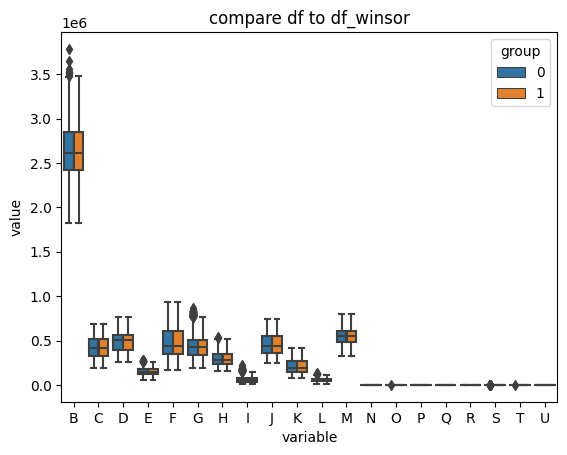

In [12]:
#compare distribution before and after winsorization over a subset of features
cols_feat = df.columns[:20].difference(['target'])
df_feat = df[cols_feat].copy(deep = True)
df_feat = df_feat.add_suffix('0')

df_winsor_feat = df_winsor[cols_feat].copy(deep = True)
df_winsor_feat = df_winsor_feat.add_suffix('1')

dfs = df_feat.copy(deep = True)
dfs[df_winsor_feat.columns] = df_winsor_feat

dfs["id"] = dfs.index
dfs = pd.wide_to_long(dfs, stubnames=cols_feat, i='id', j='group').reset_index().drop('id', axis=1)


dfs = dfs.melt(id_vars='group')
ax = sns.boxplot(data=dfs, x='variable', y='value', hue='group')
ax.set_xticklabels([textwrap.fill(t.get_text(), 1)  for t in ax.get_xticklabels()])
ax.set_title('compare df to df_winsor')

### Check for MultiCollinearity

We removed one feature from each pair where the pairwise correlation is greater than 0.75. We removed the one with less correlation with the target

In [13]:
#borrowed from https://www.kaggle.com/code/jbptest/notebookda5cf621c0/notebook
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():

    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold
        self.ls_col_remove = []

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)

            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to
            #central limit theorem
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity

        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)
        #Creating the required dataframe, then dropping the target row
        #and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)
        #print(corrWithTarget, '\n')
        #corrWithTarget.to_csv('data/corrWithTarget.csv')
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():
                if(row[column]>self.threshold) and (row[column]<1):
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        #print(colCorr, '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()
        for idx, row in corrWithTarget.iterrows():
            #print(idx, '\n')
            if (idx in colCorr):
                #print(idx,row, '\n')
                self.ls_col_remove.append(idx)
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features)
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()
        #return self.df
        return self.df, self.ls_col_remove

In [14]:
y_col = 'target'
corr_th = 0.75
corrMatrix = df_winsor.corr(method='pearson', min_periods=30).abs()
corrWithTarget = pd.DataFrame(corrMatrix.loc[:,y_col]).drop([y_col], axis = 0).sort_values(by = y_col,ascending=False)
#corrWithTarget.head()

#remove highly correlated features that is least correlated with the target
df_fill_xy = df_winsor

my_eliminator = MultiCollinearityEliminator(df_fill_xy, y_col, corr_th)
df_remove_coll,ls_removed_col = my_eliminator.autoEliminateMulticollinearity()
print('Number of kept variables', len(df_remove_coll.columns.difference([y_col])))
print('Number of removed variables', len(ls_removed_col))

Number of kept variables 54
Number of removed variables 86


In [15]:
#Convert target column to binary
cut_th = 0
df_remove_coll['bi_target'] = (df_remove_coll[y_col] >= cut_th).astype(int)
df_remove_coll.head()

,B,D,E,M,W,Y,Z,AA,AC,AF,...,EB,EC,ED,EE,EG,EH,EI,EJ,target,bi_target
date,,,,,,,,,,,,,,,,,,,,,
2010-05-11,2942038.0,666195,237550,619920,21.1,59,67.0,21,37,83.0,...,50.000000,44.444444,100.000000,58.396281,94.733871,56.908569,0.000000,100.000000,-0.022168,0
2010-05-18,2693820.0,575157,252530,559471,20.8,51,61.0,18,35,75.0,...,100.000000,44.444444,66.373561,45.539145,100.000000,33.870299,75.645396,84.757533,0.054593,1
2010-05-25,2764954.0,582890,259962,612282,22.1,56,67.0,19,38,82.0,...,33.333333,44.444444,100.000000,100.000000,89.861026,47.544377,73.485727,58.336437,-0.033822,0
2010-06-01,2785745.0,576351,259962,616411,22.1,59,68.0,19,37,85.0,...,66.666667,77.777778,99.956219,75.420299,95.141226,32.802526,21.329433,96.803486,0.031250,1
2010-06-08,2781085.0,566383,259962,644369,23.2,58,63.0,18,37,80.0,...,33.333333,77.777778,99.555033,37.831553,81.901282,22.600610,60.021633,89.504776,0.045053,1


In [16]:
# check for missing data again
missing_data2=pd.DataFrame(df_remove_coll.isnull().sum().reset_index())
missing_data2.columns=["index","missingcount"]
missing_data2=missing_data2[missing_data2["missingcount"]>0]
missing_data2['missingper']=(missing_data2['missingcount']/df_remove_coll.shape[0])*100
missing_data2.sort_values(by="missingper",ascending=True)

,index,missingcount,missingper


### Data Scaling

In [17]:

std_scaler = StandardScaler()

df_remove_coll_X = df_remove_coll[df_remove_coll.columns.difference([y_col,'bi_target'])]
df_remove_coll_X_scaled = pd.DataFrame(std_scaler.fit_transform(df_remove_coll_X), columns = df_remove_coll.columns.difference([y_col,'bi_target']), index = df_remove_coll.index)
df_remove_coll_scaled = df_remove_coll_X_scaled.copy()
df_remove_coll_scaled[[y_col,'bi_target']] = df_remove_coll[[y_col,'bi_target']]

In [18]:
# check for missing data again
missing_data2=pd.DataFrame(df_remove_coll_scaled.isnull().sum().reset_index())
missing_data2.columns=["index","missingcount"]
missing_data2=missing_data2[missing_data2["missingcount"]>0]
missing_data2['missingper']=(missing_data2['missingcount']/df_remove_coll_scaled.shape[0])*100
missing_data2.sort_values(by="missingper",ascending=True)

,index,missingcount,missingper


### Check for stationary for ARIMA model

In [20]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    #print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        return 'Stationary'
        #print("Strong evidence against the null hypothesis")
        #print("Reject the null hypothesis")
        #print("Data has no unit root and is stationary")
    else:
        return 'Not Stationary'
        #print("Weak evidence against the null hypothesis")
        #print("Fail to reject the null hypothesis")
        #print("Data has a unit root and is non-stationary")

In [21]:
dict_station = {}
df_station = df_remove_coll.copy()
for col in df_remove_coll.columns.difference(['bi_target']):
    #print('check stationarity of variable', col)
    dict_station[col] = adf_test(df_station[col])
    if dict_station[col] =='Not Stationary' :
        print(col, adf_test(df_station[col]))
        df_station[col] = df_station[col].diff()

Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
AG Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
AM Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
AP Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
AY Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
B Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
BE Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
BM Not Stationary
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augmented Dickey-Fuller Test: 
Augment

df_station convert columns that are not stationary to stationary. One thing to note is that the target variable column is actually stationary

In [22]:
df_station.dropna(inplace = True)
df_station_X = df_station[df_station.columns.difference([y_col,'bi_target'])]
df_station_scaled = pd.DataFrame(std_scaler.fit_transform(df_station_X), columns = df_station.columns.difference([y_col,'bi_target']), index = df_station.index)
df_station_scaled = df_station_scaled.copy()
df_station_scaled[[y_col,'bi_target']] = df_station[[y_col,'bi_target']]

missing_data3=pd.DataFrame(df_station_scaled.isnull().sum().reset_index())
missing_data3.columns=["index","missingcount"]
missing_data3=missing_data3[missing_data3["missingcount"]>0]
missing_data3['missingper']=(missing_data3['missingcount']/df_station_scaled.shape[0])*100
missing_data3.sort_values(by="missingper",ascending=True)

,index,missingcount,missingper


In [23]:
df_remove_coll_scaled.to_csv('saved_data/df_remove_coll_scaled.csv')
df_station_scaled.to_csv('saved_data/df_station_scaled.csv')

## Q2b: KNN-DTW Model

In [24]:
### READ DATA ###
df = pd.read_csv('saved_data/df_remove_coll_scaled.csv',index_col = 0)
df.head()

,AA,AC,AF,AG,AJ,AK,AL,AM,AO,AP,...,EG,EH,EI,EJ,M,W,Y,Z,target,bi_target
date,,,,,,,,,,,,,,,,,,,,,
2010-05-11,0.639493,-0.679661,-0.463059,-0.905171,0.676805,-0.542846,1.059852,0.414403,-0.020169,-1.088885,...,1.685483,0.370869,-1.826224,1.932708,0.770817,0.104796,-0.045212,-0.093926,-0.022168,0
2010-05-18,-0.280400,-1.199177,-1.527085,-1.439397,0.676805,2.495230,1.487810,-0.162185,-0.143268,-0.996600,...,1.868164,-0.475042,0.906274,1.347916,0.100422,-0.024703,-1.309273,-0.818270,0.054593,1
2010-05-25,0.026231,-0.419904,-0.596063,-1.795547,0.676805,-1.171272,0.337537,0.549070,-0.028578,-1.263794,...,1.516444,0.027038,0.828261,0.334246,0.686110,0.536460,-0.519234,-0.093926,-0.033822,0
2010-06-01,0.026231,-0.679661,-0.197053,-1.023888,0.676805,-0.958460,0.368796,0.548260,-0.411949,-1.179210,...,1.699614,-0.514248,-1.055752,1.810071,0.731901,0.536460,-0.045212,0.026798,0.031250,1
2010-06-08,-0.280400,-0.679661,-0.862069,-1.201963,0.676805,1.309638,1.280834,0.540841,-0.133370,-1.304944,...,1.240322,-0.888838,0.341905,1.530049,1.041963,1.011290,-0.203219,-0.576822,0.045053,1



*   If the original dataset has n datapoints, and the lookback window is p, then there will be n - p samples. For each sample, we conduct dynamic time warping (DTW) on two multivariate time series of dimension k * p(k is the feature dimension, including both features and lagged target)
*   We choose a subset of features to reduce the computation burden of DTW


In [25]:
#find columns that have the highest correlation with the response variable
corrMatrix= df[df.columns.difference(['bi_target'])].corr(method='pearson', min_periods=30).abs()
corrWithTarget = pd.DataFrame(corrMatrix.loc[:,'target']).drop(['target'], axis = 0)
corrWithTarget = corrWithTarget.sort_values(by = 'target',ascending=False)
corrWithTarget.head(5).index

Index(['DR', 'AP', 'D', 'DA', 'B'], dtype='object')

In [26]:
# transform univariate time series to supervised learning problem

# split a univariate sequence into X (lag1) and y for supervised learning
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#split a univariate sequence into X(lag0) supervised learning
def split_sequence2(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x= sequence[i+1:end_ix+1]
        X.append(seq_x)
    return array(X)

n_window = 50
# transform to a supervised learning problem
X_real, y_real = split_sequence(sequence = df['target'].to_numpy(), n_steps = n_window)
ls_cova_arr = [X_real]
for col in list(corrWithTarget.head(5).index):
    ls_cova_arr.append(split_sequence2(sequence = df[col].to_numpy(), n_steps = n_window))

X_cat, y_cat = split_sequence(sequence = df['bi_target'].to_numpy(), n_steps = n_window)
print(X_real.shape, y_cat.shape)

ts_arr_3d = np.stack( ls_cova_arr, axis = 1)
print(ts_arr_3d.shape)

(628, 50) (628,)
(628, 6, 50)


In [27]:

#If you use the code in your work please cite as
#@misc{DTW_D,
#title={Multivariate time series dynamic time warping using euclidean distance},
#author={Ali Javed},
#year={2019},
#month={November},
#note = {\url{https://github.com/ali-javed/dynamic-time-warping}}
#}



def sq_euc(s1, s2):
#Inputs
#s1: signal 1, m * n. where m is the number of variables, n is the timesteps.
#s2: signal 2, m * n. where m is the number of variables, n is the timesteps.

#OUTPUT
#dist: Squared euclidean distance

    dist = ((s1 - s2) ** 2)
    return dist.flatten().sum()


def dtw_d(s1, s2, w):
#author: Ali Javed
#email: ajaved@uvm.edu

#INPUTS:
#s1: signal 1, m * n. where m is the number of variables, n is the timesteps.
#s2: signal 2, m * n. where m is the number of variables, n is the timesteps.
#w: window parameter, percent of size and is between0 and 1. 0 is
#euclidean distance while 1 is maximum window size.
#
#OUTPUTS:
#dist: resulting distance


    s1 = np.asarray(s1)
    s2 = np.asarray(s2)
    s1_shape = np.shape(s1)
    s2_shape = np.shape(s2)

    if w<0 or w>1:
        print("Error: W should be between 0 and 1")
        return False
    if s1_shape[0] != s2_shape[0]:
        print("Error: Please check input dimensions. Number of variables not consistent.")
        return False
    if s1_shape[1] != s2_shape[1]:
        print("Warning: Length of time series not equal")

    #if window size is zero, it is plain euclidean distance
    if w ==0:
        dist = np.sqrt(sq_euc(s1, s2))
        return dist


    #get absolute window size
    w = int(np.ceil(w * s1_shape[1]))

    #adapt window size

    w=int(max(w, abs(s1_shape[1]- s2_shape[1])));


    #initilize
    DTW = {}
    for i in range(-1, s1_shape[1]):
        for j in range(-1, s2_shape[1]):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(s1_shape[1]):
        for j in range(max(0, i - w), min(s2_shape[1], i + w)):
            #squared euc distance
            dist = sq_euc(s1[:,i], s2[:,j])
            #find optimal path
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])

    dist = np.sqrt(DTW[s1_shape[1] - 1, s2_shape[1] - 1])


    return dist

In [28]:
#### dtw and knn ####
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays

    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN

    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function

    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]

    distance_fun: int, if 1: use dtw_d, if 2: use _dtw_distance
    """

    def __init__(self, n_neighbors=5, max_warping_window=10000, distance_fun = 1, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
        self.distance_fun = distance_fun

    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer

        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """

        self.x = x
        self.l = l

    #def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: np.sqrt(sq_euc(x, y))):

        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared

        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function

        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = ts_a.shape[1], ts_b.shape[1]
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[:,0], ts_b[:,0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[:,i], ts_b[:,0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[:,0], ts_b[:,j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[:,i], ts_b[:,j])

        # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]

        y : array of shape [n_samples, n_timepoints]

        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """

        # Compute the distance matrix
        dm_count = 0

        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        #if(np.array_equal(x, y)):
        if(x.shape[0]==y.shape[0]):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            p = ProgressBar(shape(dm)[0])
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    ts_a,ts_b = x[i, :, ::self.subsample_step],y[j, :, ::self.subsample_step]
                    if self.distance_fun == 1:
                        dm[dm_count] = dtw_d(ts_a,ts_b, w = 1)
                    else:
                        dm[dm_count] = self._dtw_distance(ts_a,ts_b)

                    dm_count += 1
                    if dm_count % 10== 0:
                      p.animate(dm_count)

            # Convert to squareform
            dm = squareform(dm)
            return dm

        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0]*y_s[0]

            p = ProgressBar(dm_size)
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    ts_a,ts_b = x[i,:,::self.subsample_step],y[j,:, ::self.subsample_step]
                    if self.distance_fun == 1:
                        dm[i, j] = dtw_d(ts_a,ts_b, w = 1)
                    else:
                        dm[i, j] = self._dtw_distance(ts_a,ts_b)

                    # Update progress bar
                    dm_count += 1
                    if dm_count % 10== 0:
                      p.animate(dm_count)

            return dm

    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified

        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels
              (2) the knn label count probability
        """

        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]

        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

In [32]:
class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r',self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

## Q2c: What evaluation metric(s) have you picked and why
We look at the following evaluation metrics:


*   Precision, recall, f1:
We want to capture as many positive labels and negative labelsas possible, but at the same time, we also want more predicted positive to be actual positive and more predicted negative to be actual negative, so we look at both recall and precision and their harmonic mean, f1 score
*  Since the data is quite balanced (see below), We use ROC-AUC curve to compare each more to a random model and evaluate its performance
*   cross entropy is calculated for comparing the KNN-DTW method to other statistical method and deep learning method



<Axes: ylabel='bi_target'>

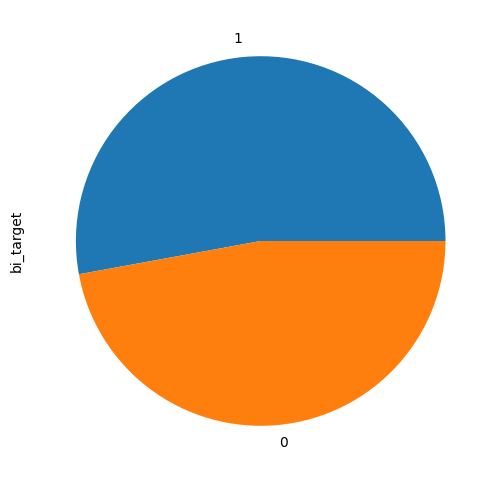

In [ ]:
#We look at both recall, and precision and the ROC-AUC curve is the response variable since is quite balanced
### PLOT BINARY LABEL DISTRIBUTION ###
df['bi_target'].value_counts().plot.pie(figsize=(6,6))

We split the entire dataset into train and test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(ts_arr_3d, y_cat, shuffle=False, train_size=0.7)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(439, 6, 50) (439,)
(189, 6, 50) (189,)



*   Then we set the test dataset aside, and conduct 5-fold cross validation and hyperparameter tuning from the training dataset
*   Hyperparameters include number of neighbors, max warping window
* Because of time and computation constraints, we only considered five covariates, and looked back 50 data points. For future work, we could also compare performance across different sets of covariates and across various look-back windows




### Hyperparameter Tuning and cross-validation

In [49]:
from sklearn.model_selection import StratifiedKFold
def cv_nfolds(X, y,
                                     n_folds = 10,
                                     n_neighbors = 5,
                                     max_warping_window = 10,
                                     shuffle = False
                            ):

    clf = KnnDtw(n_neighbors=n_neighbors, max_warping_window=max_warping_window)
    k_fold = StratifiedKFold(n_splits = n_folds , shuffle = False)
    criterion = torch.nn.BCEWithLogitsLoss()

    f1_macros = []
    precision_macros = []
    recall_macros = []
    ces = []
    aucs = []
    y_tests = []
    y_probas = []
    #fpr_array = []
    #tpr_array = []
    for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred, y_proba = clf.predict(X_test) #y_pred is label
        y_tests.append(y_test)
        y_probas.append(y_proba)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        precision_macro= precision_score(y_test, y_pred, average='macro')
        recall_macro = recall_score(y_test, y_pred, average='macro')
        f1_macros.append(f1_macro)
        precision_macros.append(precision_macro)
        recall_macros.append(recall_macro)
        y_test_tensor = torch.tensor(y_test)
        y_pred_tensor = torch.tensor(y_pred)
        ce = criterion(y_pred_tensor.float(),y_test_tensor.float())
        #ces.append(ce.to_numpy())
        ces.append(np.array(ce))

        #ROC AUC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        #fpr_array.append(fpr)
        #tpr_array.append(tpr)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_test,y_pred)
        aucs.append(auc)
        lab_fold = 'Fold %d AUC=%.4f' % (i+1, auc)
        # Now, plot the computed values
        plt.plot(fpr, tpr, label=lab_fold)
    res_dict = {}
    res_dict['mean_precision'] = np.mean(precision_macros, axis=0)
    res_dict['std_precision'] = np.std(precision_macros, axis=0)
    res_dict['mean_recall'] = np.mean(recall_macros, axis=0)
    res_dict['std_recall'] = np.std(recall_macros, axis=0)
    res_dict['mean_f1'] = np.mean(f1_macros, axis=0)
    res_dict['std_f1'] = np.std(f1_macros, axis=0)
    res_dict['mean_ce'] = np.mean(ces, axis=0)
    res_dict['std_ce'] = np.std(ces, axis=0)

    # Custom settings for the plot
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
    lab=r'Mean (AUC = %0.3f $\pm$ %0.2f)' % (np.mean(aucs), np.std(aucs))
    y_test_con = np.concatenate(y_tests)
    y_proba_con = np.concatenate(y_probas)
    fpr_con, tpr_con, thresholds_con = roc_curve(y_test_con, y_proba_con)
    plt.plot(fpr_con, tpr_con, lw=4, color='red', label=lab)
    #tpr_array = np.array(tpr_array)
    #mean_tpr = np.mean(tpr_array, axis=0)
    #std_tpr = np.std(tpr_array, axis=0)
    #plt.fill_between(fpr_array, mean_tpr + std_tpr, mean_tpr - std_tpr, alpha=0.3, linewidth=0, color='grey')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.show()   # Display

    return res_dict

Since this notebook is implemented on google colab, each time only one set of hyperparameters was tested. The below two cells showed the performance of two sets of hyperparameters:


1.   n_neighbors = 5, max_warping_window = 5
2.   n_neighbors = 8, max_warping_window = 10



Streaming output truncated to the last 5000 lines.
 [*****************84%************      ]  25625 of 30624 complete
 [*****************84%************      ]  25626 of 30624 complete
 [*****************84%************      ]  25627 of 30624 complete
 [*****************84%************      ]  25628 of 30624 complete
 [*****************84%************      ]  25629 of 30624 complete
 [*****************84%************      ]  25630 of 30624 complete
 [*****************84%************      ]  25631 of 30624 complete
 [*****************84%************      ]  25632 of 30624 complete
 [*****************84%************      ]  25633 of 30624 complete
 [*****************84%************      ]  25634 of 30624 complete
 [*****************84%************      ]  25635 of 30624 complete
 [*****************84%************      ]  25636 of 30624 complete
 [*****************84%************      ]  25637 of 30624 complete
 [*****************84%************      ]  25638 of 30624 complete
 [*********

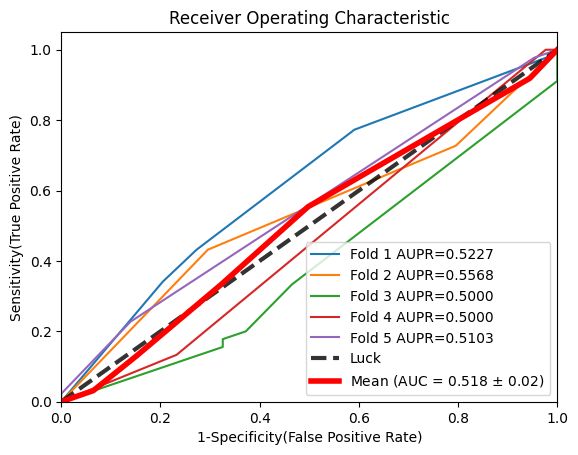

In [50]:
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

cv_res_dict = {}
n_neighbors = 10
max_warping_window = 10
cv_res_dict[(n_neighbors,max_warping_window)] = cv_nfolds(X_train, y_train,
          n_folds = 5,
          n_neighbors = n_neighbors,
          max_warping_window = max_warping_window,
          shuffle = False)

In [48]:
cv_res_dict

{(5, 5): {'mean_precision': 0.5048937623172904,
  'std_precision': 0.1594345009273652,
  'mean_recall': 0.5110559079163731,
  'std_recall': 0.02467039321450301,
  'mean_f1': 0.4246092740405282,
  'std_f1': 0.06734013616610124,
  'mean_ce': 0.73952967,
  'std_ce': 0.045891438}}

In [34]:
cv_res_dict[(8, 10)]

{(8, 10): {'mean_precision': 0.540304606512505,
  'std_precision': 0.1647824687083463,
  'mean_recall': 0.536000704721635,
  'std_recall': 0.04041493419140911,
  'mean_f1': 0.4493869123372045,
  'std_f1': 0.08939734828283272,
  'mean_ce': 0.7245754,
  'std_ce': 0.05163368}}

In [51]:
cv_res_dict[(10, 10)]

{'mean_precision': 0.4298431707296662,
 'std_precision': 0.14862714271880564,
 'mean_recall': 0.517970401691332,
 'std_recall': 0.021148915241823902,
 'mean_f1': 0.4169831108138693,
 'std_f1': 0.07525710438850453,
 'mean_ce': 0.73093647,
 'std_ce': 0.04680914}

Next, we choose the optimal set of hyperparameters, train the model and evaluate the performance

In [ ]:
#train the model
clf = KnnDtw(n_neighbors=8, max_warping_window=10)
clf.fit(X_train, y_train)

y_pred, y_proba = clf.predict(X_test) #y_pred is label

Streaming output truncated to the last 5000 lines.
 [*********        24%                  ]  20152 of 82971 complete
 [*********        24%                  ]  20153 of 82971 complete
 [*********        24%                  ]  20154 of 82971 complete
 [*********        24%                  ]  20155 of 82971 complete
 [*********        24%                  ]  20156 of 82971 complete
 [*********        24%                  ]  20157 of 82971 complete
 [*********        24%                  ]  20158 of 82971 complete
 [*********        24%                  ]  20159 of 82971 complete
 [*********        24%                  ]  20160 of 82971 complete
 [*********        24%                  ]  20161 of 82971 complete
 [*********        24%                  ]  20162 of 82971 complete
 [*********        24%                  ]  20163 of 82971 complete
 [*********        24%                  ]  20164 of 82971 complete
 [*********        24%                  ]  20165 of 82971 complete
 [*********

From below classification metrics report and confusion metrics, we can see that this specific configuration of KNN-DTW model achieved better recall score (0.64) for the negative class, and better precision scaore (0.58) for the positive class. The overall AUC is 0.51, weighted precision, recall are 0.51, all sugguesting that this model is just slightly better than a random model

In [ ]:
#evaluation on validation set
proba_th = 0.5
y_val = y_test
#y_pred = label
# balanced_accuracy_score is defined as the average of recall obtained on each class.

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.64      0.52        81
           1       0.58      0.37      0.45       108

    accuracy                           0.49       189
   macro avg       0.51      0.51      0.48       189
weighted avg       0.52      0.49      0.48       189



[[52 29]
 [68 40]]
balanced_accuracy: 0.5062
f1_macro: 0.4847
all f1: 0.5174 0.4520


Text(0.5, 1.0, 'Macro F1: 0.48,precision: 0.51,recall: 0.51')

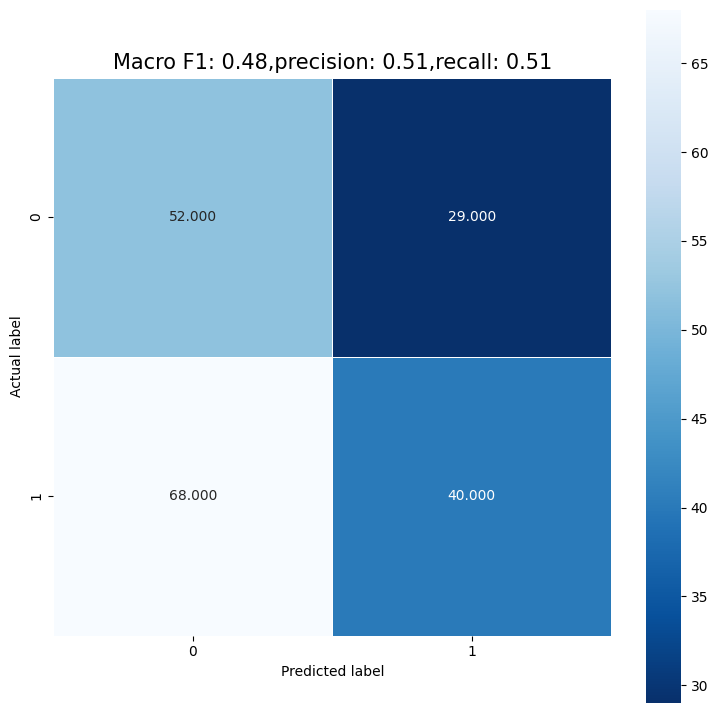

In [ ]:
#confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(cm)

b_score = balanced_accuracy_score(y_val, y_pred)
b_score = round(b_score,4)
print('balanced_accuracy: ' + '{:.4f}'.format(b_score))


#f1 score

#macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
f1_macro = f1_score(y_val, y_pred, average='macro')
ls_f1 = f1_score(y_val, y_pred, average=None)
precision1 = precision_score(y_val, y_pred, average=None)[1]
recall1 = recall_score(y_val, y_pred, average=None)[1]
precision_macro= precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
print('f1_macro: ' + '{:.4f}'.format(f1_macro))
print('all f1: ' + " ".join("%.4f" % x for x in ls_f1))

#visualize confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Macro F1: '+'{:.2f}'.format(f1_macro) + ',precision: {:.2f}'.format(precision_macro)+ ',recall: {:.2f}'.format(recall_macro)
plt.title(all_sample_title, size = 15)

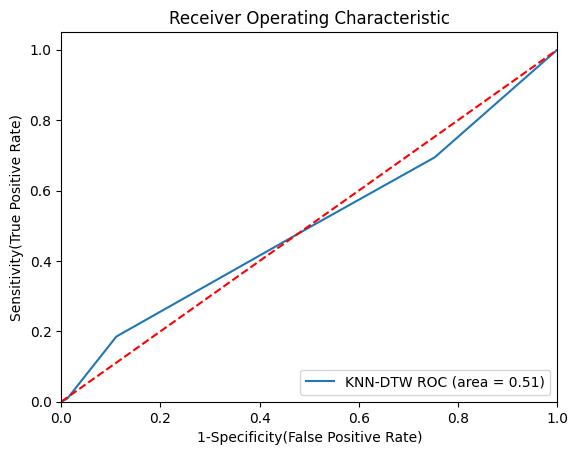

In [ ]:
#ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
# Calculate Area under the curve to display on the plot
auc = roc_auc_score(y_val,y_pred)
# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNN-DTW', auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
#cross entropy

y_val_tensor = torch.tensor(y_val)
y_pred_tensor = torch.tensor(y_pred)
criterion = torch.nn.BCEWithLogitsLoss()
print('KNN-DTW BCE loss: ',criterion(y_pred_tensor.float(),y_val_tensor.float()))

KNN-DTW BCE loss:  tensor(0.7079)


## Statistical Model Arima

In [ ]:
### READ DATA ###
df = pd.read_csv('saved_data/df_remove_coll_scaled.csv',index_col = 0)
#df = pd.read_csv('saved_data/df_station_scaled.csv',index_col = 0)
#include lagged target numerical values as features
df['target'] = df['target'].shift()
df.dropna(inplace = True)
df.head()

,AA,AC,AF,AG,AJ,AK,AL,AM,AO,AP,...,EG,EH,EI,EJ,M,W,Y,Z,target,bi_target
date,,,,,,,,,,,,,,,,,,,,,
2010-05-18,-0.280400,-1.199177,-1.527085,-1.439397,0.676805,2.495230,1.487810,-0.162185,-0.143268,-0.996600,...,1.868164,-0.475042,0.906274,1.347916,0.100422,-0.024703,-1.309273,-0.818270,-0.022168,1
2010-05-25,0.026231,-0.419904,-0.596063,-1.795547,0.676805,-1.171272,0.337537,0.549070,-0.028578,-1.263794,...,1.516444,0.027038,0.828261,0.334246,0.686110,0.536460,-0.519234,-0.093926,0.054593,0
2010-06-01,0.026231,-0.679661,-0.197053,-1.023888,0.676805,-0.958460,0.368796,0.548260,-0.411949,-1.179210,...,1.699614,-0.514248,-1.055752,1.810071,0.731901,0.536460,-0.045212,0.026798,-0.033822,1
2010-06-08,-0.280400,-0.679661,-0.862069,-1.201963,0.676805,1.309638,1.280834,0.540841,-0.133370,-1.304944,...,1.240322,-0.888838,0.341905,1.530049,1.041963,1.011290,-0.203219,-0.576822,0.031250,1
2010-06-15,-0.587031,-0.679661,-0.862069,-1.558113,0.676805,-0.149863,0.022007,0.729095,-0.166481,-1.140395,...,0.955725,-1.223939,0.021624,0.828541,0.764440,0.752291,-0.203219,-0.697546,0.045053,1


Choose five features that are mostly positively correlated with the target as external covariates. Note that these features have already passed multicollinearity

In [ ]:
corrMatrix= df[df.columns.difference(['bi_target'])].corr(method='pearson', min_periods=30).abs()
corrWithTarget = pd.DataFrame(corrMatrix.loc[:,'target']).drop(['target'], axis = 0)
corrWithTarget = corrWithTarget.sort_values(by = 'target',ascending=False)
corrWithTarget.head(5).index

Index(['DU', 'CD', 'EJ', 'DA', 'EH'], dtype='object')

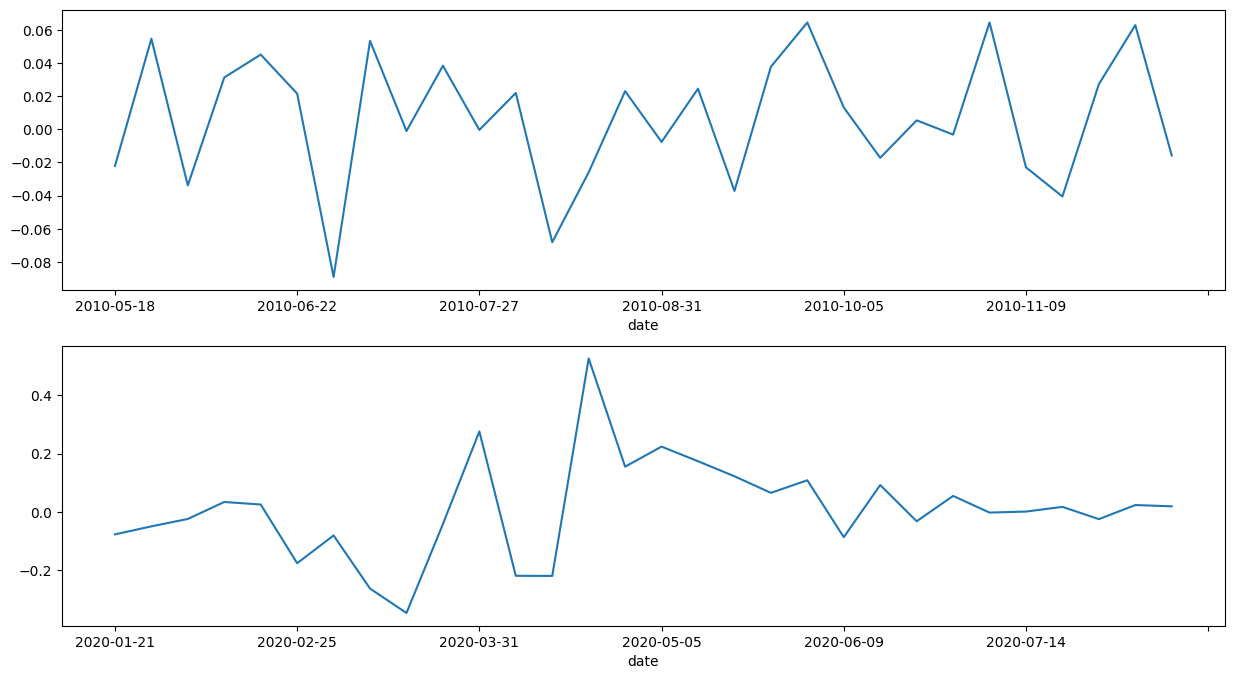

In [ ]:
#visualize the progression of response variable at two different times with different volatility
fig,ax = plt.subplots(2,1,figsize=(15,8))
df['target'][0:30].plot(ax = ax[0])
df['target'][500:530].plot(ax = ax[1])
plt.show()

In [ ]:
#check causality

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gc_mt = grangers_causation_matrix(df, variables = df.columns)
gc_mt[-2:]


,AA_x,AC_x,AF_x,AG_x,AJ_x,AK_x,AL_x,AM_x,AO_x,AP_x,...,EG_x,EH_x,EI_x,EJ_x,M_x,W_x,Y_x,Z_x,target_x,bi_target_x
target_y,0.1078,0.0070,0.2979,0.1419,0.0920,0.1897,0.0029,0.0776,0.0305,0.0001,...,0.0256,0.1098,0.1107,0.1441,0.0302,0.1250,0.0013,0.1439,1.0000,0.0
bi_target_y,0.0642,0.1316,0.4214,0.1106,0.0112,0.0123,0.1338,0.1371,0.0691,0.0319,...,0.4328,0.0690,0.6025,0.1258,0.1513,0.1158,0.0614,0.6313,0.1649,1.0


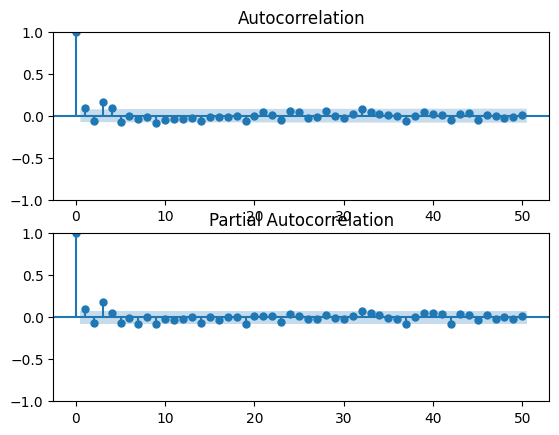

In [ ]:
### PLOT AUTOCORRELATION###

import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df['target'], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['target'], lags=50, ax=ax[1])
plt.show()

There are only a few significant autocorrelation at smaller lags for the target column, so we assume the optimal lag for the ARIMA should be small

In [ ]:
### TRAIN TEST SPLIT ###
#from sklearn.model_selection import train_test_split
#max_prediction_length = 12
#my_train_size = (len(df)-max_prediction_length)/len(df)
my_train_size = 0.7
train, test = train_test_split(df, shuffle=False, train_size=my_train_size, random_state = 1)

train.shape, test.shape

((473, 56), (204, 56))

### With no exogeneous features

In [ ]:
### FIT AND FIND BEST MODEL ###
#without exog
all_res = {}
best_model = None
best_aic, best_order = np.inf, 0

for p in range(1,20):
    for q in range(0,2):
        for d in range(0,2):
            """
            m = SARIMAX(endog = logit(train['bi_target'].clip(1e-3, 1 - 1e-3)),
                    exog = train[train.columns.difference(['bi_target'])],
                    order=(p,d,q), enforce_invertibility=False)
            """
            m = SARIMAX(endog = logit(train['bi_target'].clip(1e-3, 1 - 1e-3)),
                    order=(p,d,q), enforce_invertibility=False)
            try:
                model = m.fit(disp=False)
                all_res[(p,d,q)] = model.aic
            except:
                all_res[(p,d,q)] = np.inf

            if all_res[(p,d,q)] < best_aic:
                best_aic = all_res[(p,d,q)]
                best_order = (p,d,q)
                best_model = model

print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (1, 0, 0) BEST AIC: 3172.0052159352745


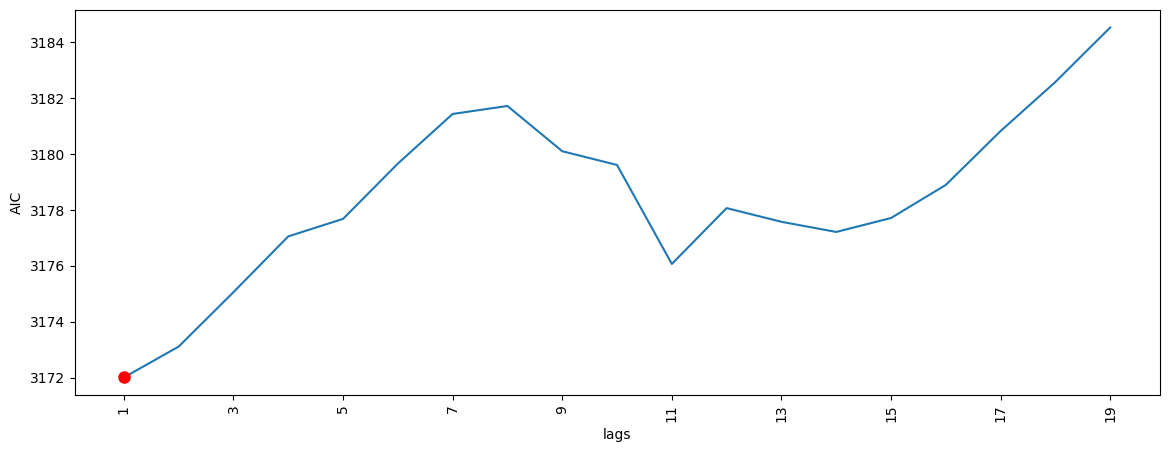

In [ ]:

# set parameter range
p = range(1,20)
d = [0]
q = [0]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
ls_aic = [all_res[key] for key in pdq]

### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(p, ls_aic)
plt.plot([best_order[0]], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(1,len(ls_aic)+1, 2), range(1,20, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

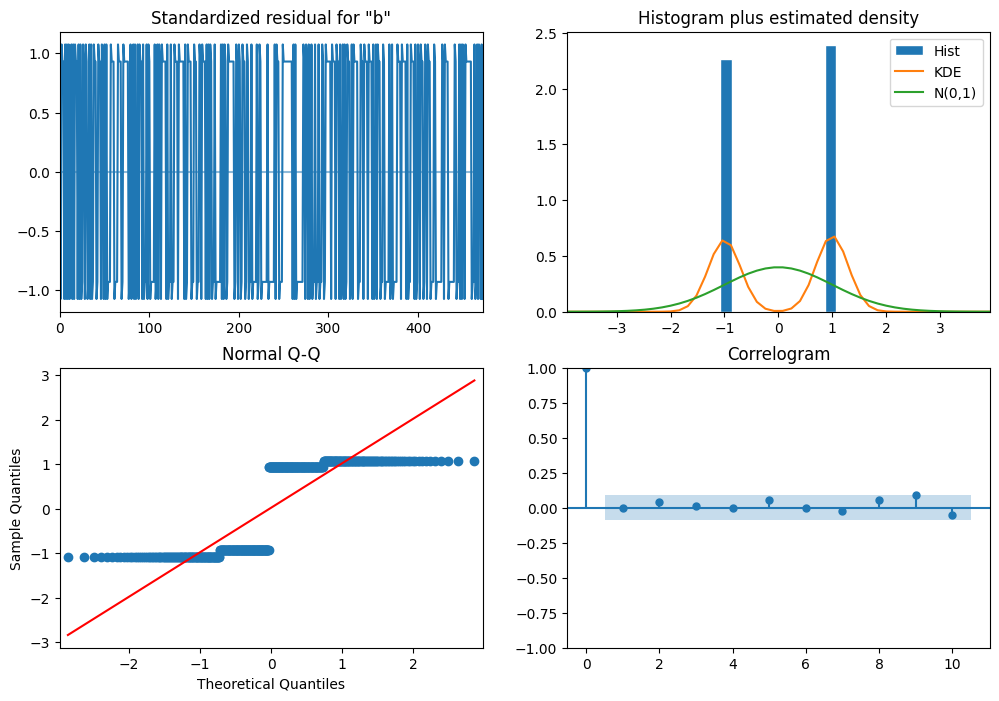

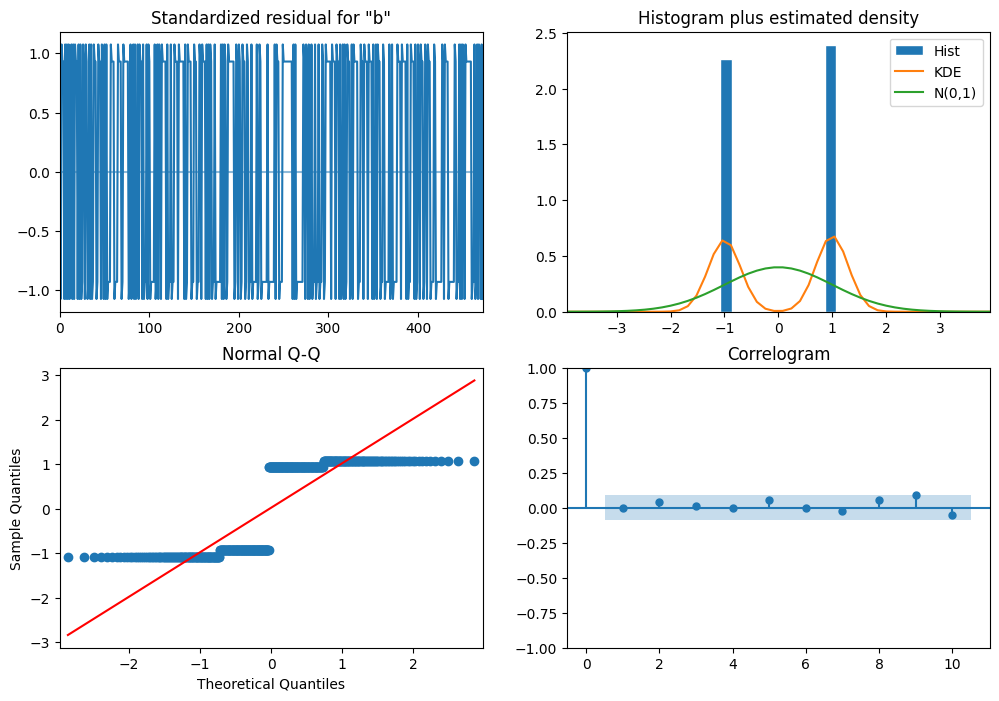

In [ ]:
best_model.plot_diagnostics(figsize=(12,8))

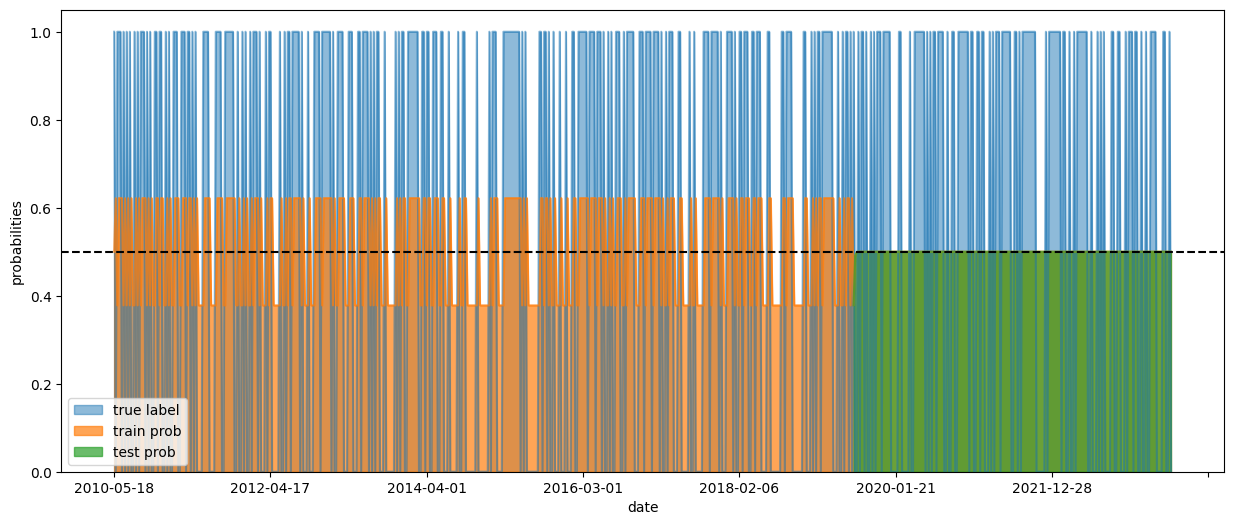

In [ ]:
### PLOT PREDICTED PROBABILITIES VS ACTUAL ###

n_forecast = test.shape[0]
predict = best_model.get_prediction(end=best_model.nobs + n_forecast - 1)
proba = expit(predict.predicted_mean)

df.bi_target.plot(alpha=0.5, kind='area', figsize=(15,6), label='true label')
proba.plot(alpha=0.7, kind='area', label='train prob')
proba[-n_forecast:].plot(alpha=0.7, kind='area', label='test prob')
plt.axhline(0.5, linestyle='--', c='black')
plt.ylabel('probabilities'); plt.legend()

In [ ]:
proba_th = 0.5
my_label = (proba >= proba_th).astype(int)
y_val = test['bi_target']
y_pred = my_label[-n_forecast:]


# balanced_accuracy_score is defined as the average of recall obtained on each class.

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.08      0.14        89
           1       0.57      0.94      0.71       115

    accuracy                           0.56       204
   macro avg       0.53      0.51      0.42       204
weighted avg       0.54      0.56      0.46       204



In [ ]:
import torch

y_val_tensor = torch.tensor(y_val)
y_pred_tensor = torch.tensor(y_pred.values)
#y_pred_tensor = torch.from_numpy(y_pred.values)

criterion = torch.nn.BCEWithLogitsLoss()
print('Arima without exog BCE loss: ',criterion(y_pred_tensor.float(),y_val_tensor.float()))

Arima without exog BCE loss:  tensor(0.7413)


[[  7  82]
 [  7 108]]
balanced_accuracy: 0.5089
f1_macro: 0.4221
all f1: 0.1359 0.7082


Text(0.5, 1.0, 'Macro F1: 0.42,precision: 0.53,recall: 0.51')

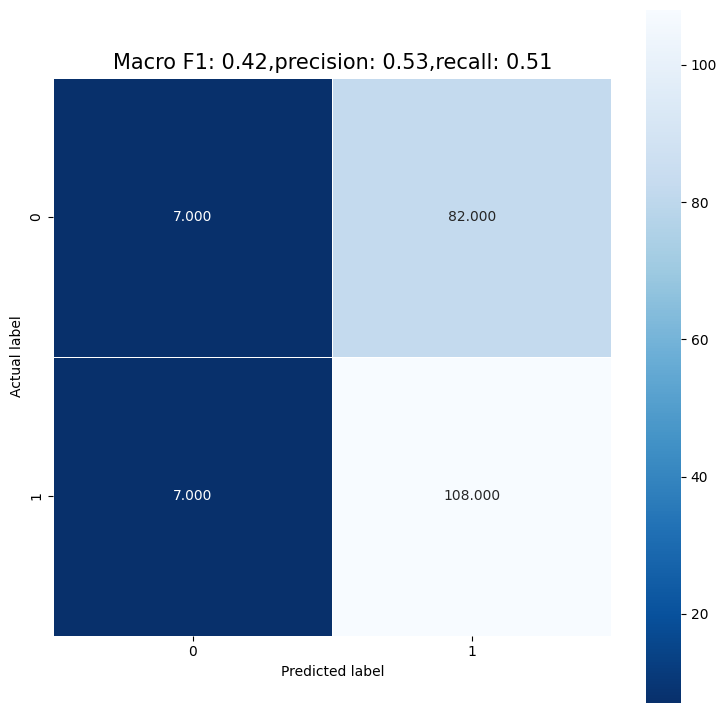

In [ ]:
#confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(cm)

b_score = balanced_accuracy_score(y_val, y_pred)
b_score = round(b_score,4)
print('balanced_accuracy: ' + '{:.4f}'.format(b_score))


#f1 score
#from sklearn.metrics import f1_score
#macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
f1_macro = f1_score(y_val, y_pred, average='macro')
ls_f1 = f1_score(y_val, y_pred, average=None)
precision1 = precision_score(y_val, y_pred, average=None)[1]
recall1 = recall_score(y_val, y_pred, average=None)[1]
precision_macro= precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
print('f1_macro: ' + '{:.4f}'.format(f1_macro))
print('all f1: ' + " ".join("%.4f" % x for x in ls_f1))

#visualize confusion matrix
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Macro F1: '+'{:.2f}'.format(f1_macro) + ',precision: {:.2f}'.format(precision_macro)+ ',recall: {:.2f}'.format(recall_macro)
plt.title(all_sample_title, size = 15)

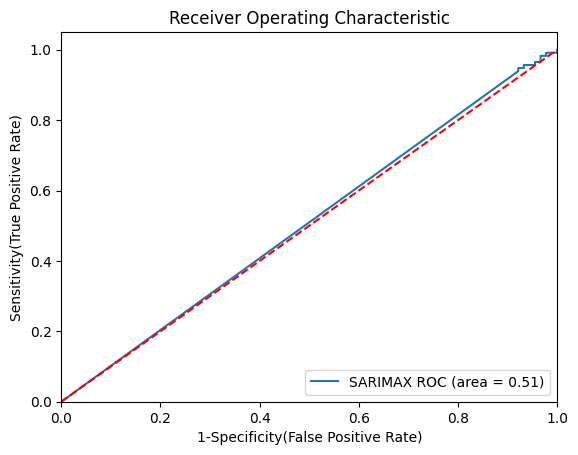

In [ ]:
#from sklearn.metrics import roc_curve
y_proba = proba[-n_forecast:]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
# Calculate Area under the curve to display on the plot
auc = roc_auc_score(y_val,y_pred)
# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SARIMAX', auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

### With exog features

In [ ]:
### FIT AND FIND BEST MODEL ###
#with exog
all_res_exog = {}
best_model_exog = None
best_aic_exog, best_order_exog = np.inf, 0

for p in range(1,20):
    for q in range(0,2):
        for d in range(0,2):

            m = SARIMAX(endog = logit(train['bi_target'].clip(1e-3, 1 - 1e-3)),
                    #exog = train[train.columns.difference(['bi_target','target'])],
                    #exog = train[train.columns.difference(['bi_target'])],
                    exog = train[list(corrWithTarget.head(5).index)+['target']],
                    order=(p,d,q), enforce_invertibility=False)

            try:
                model = m.fit(disp=False)
                all_res_exog[(p,d,q)] = model.aic
            except:
                all_res_exog[(p,d,q)] = np.inf

            if all_res_exog[(p,d,q)] < best_aic_exog:
                best_aic_exog = all_res_exog[(p,d,q)]
                best_order_exog = (p,d,q)
                best_model_exog = model

In [ ]:
print('BEST ORDER', best_order_exog, 'BEST AIC:', best_aic_exog)


BEST ORDER (1, 0, 0) BEST AIC: 3180.850378225019


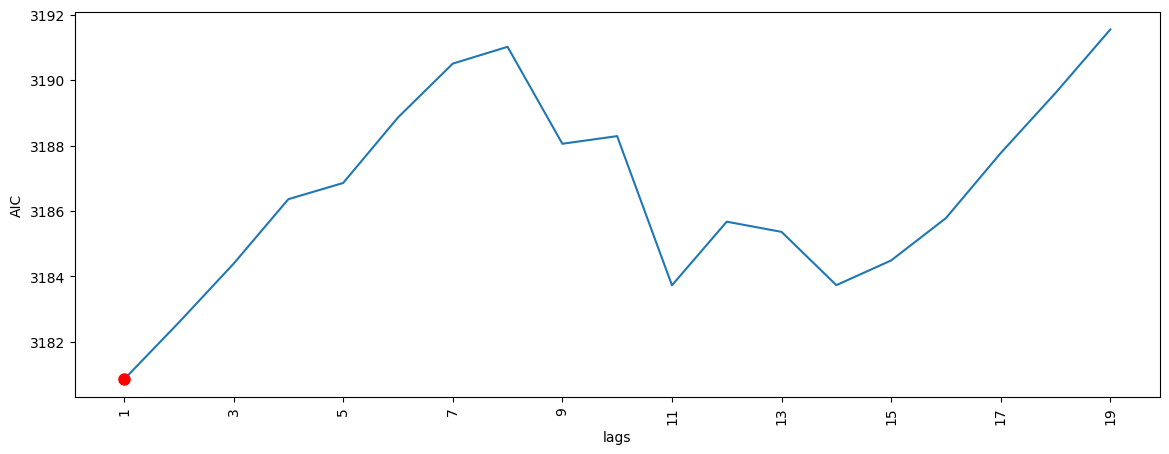

In [ ]:
# set parameter range
p = range(1,20)
d = [0]
q = [0]
#q = [0]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
ls_aic = [all_res_exog[key] for key in pdq]

### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(p, ls_aic)
plt.plot([best_order_exog[0]], [best_aic_exog], marker='o', markersize=8, color="red")
plt.xticks(range(1,len(ls_aic)+1, 2), range(1,20, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

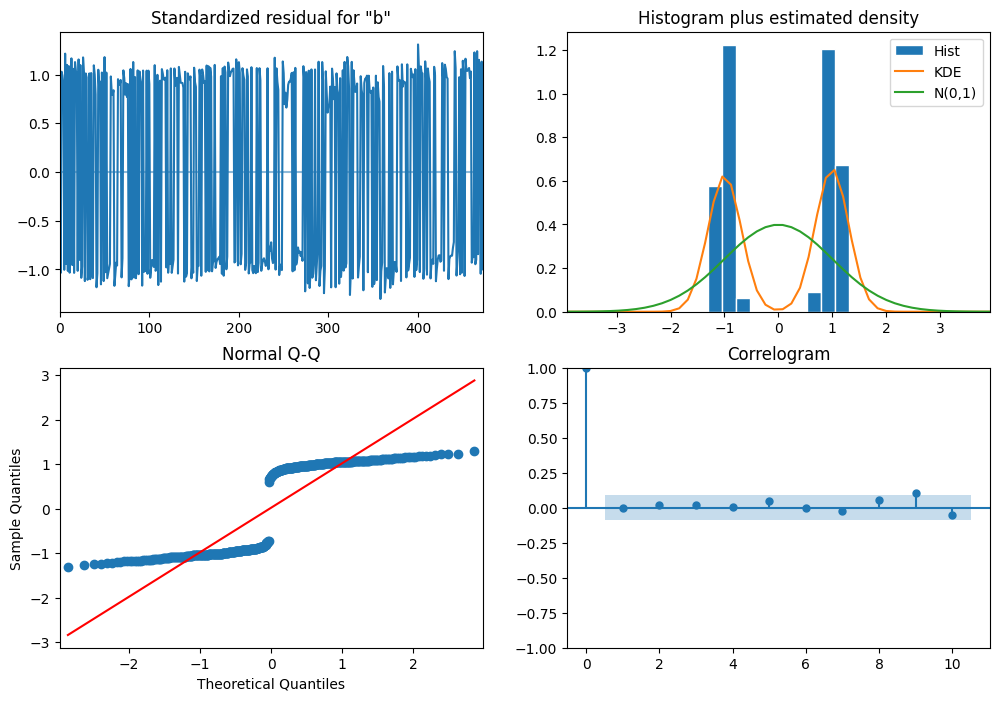

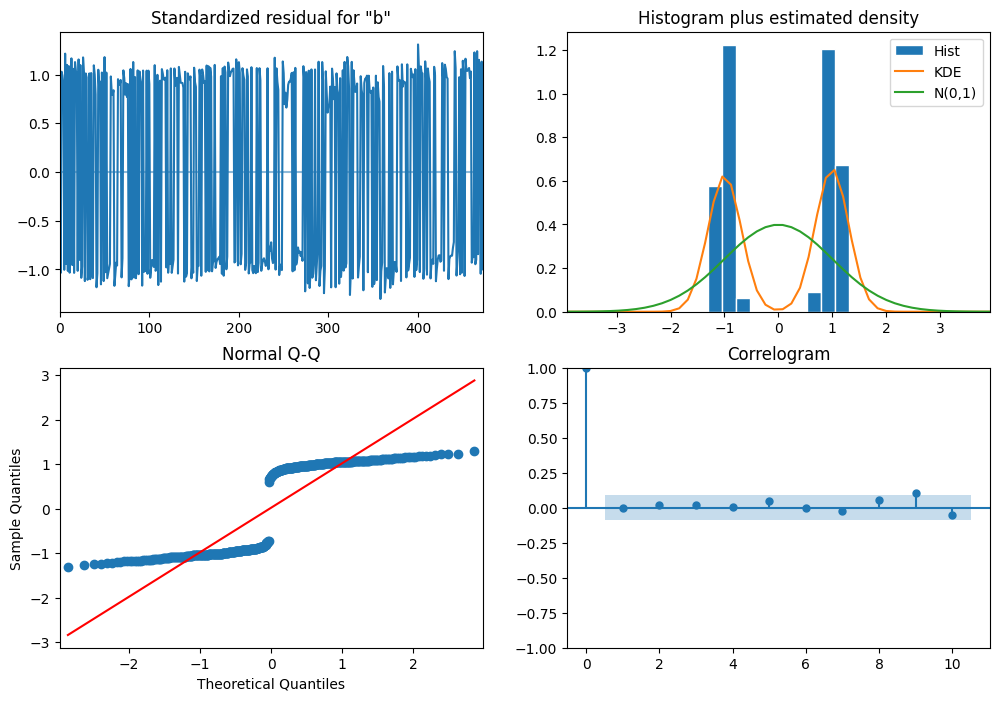

In [ ]:
best_model_exog.plot_diagnostics(figsize=(12,8))

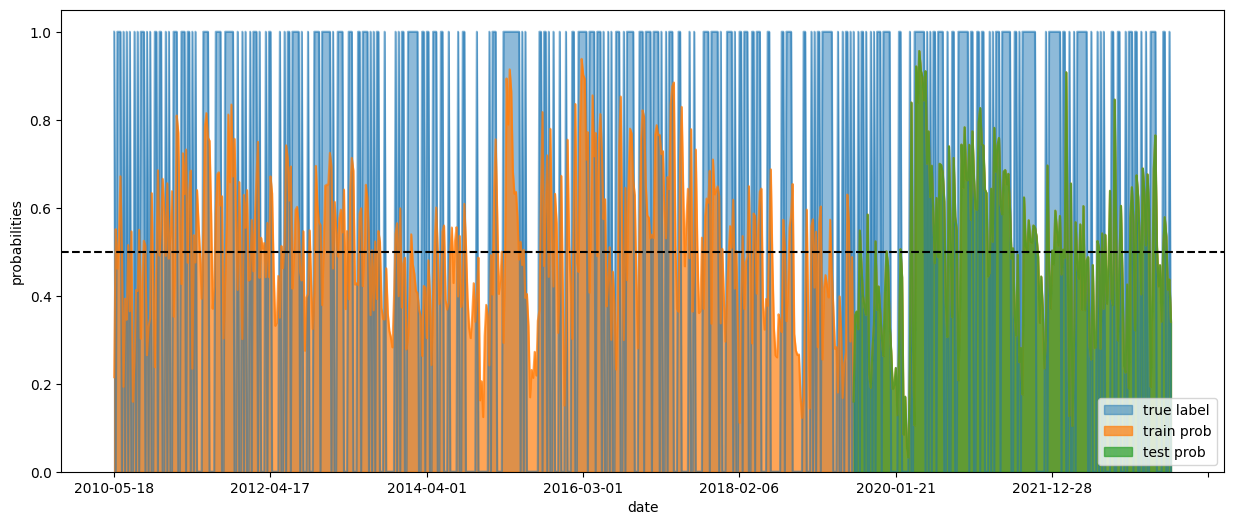

In [ ]:
### PLOT PREDICTED PROBABILITIES VS ACTUAL ###

n_forecast = test.shape[0]
predict = best_model_exog.get_prediction(end=best_model_exog.nobs + n_forecast - 1,
            #exog = test[test.columns.difference(['bi_target'])]
            exog = test[list(corrWithTarget.head(5).index)+['target']]
            )
proba = expit(predict.predicted_mean)

df.bi_target.plot(alpha=0.5, kind='area', figsize=(15,6), label='true label')
proba.plot(alpha=0.7, kind='area', label='train prob')
proba[-n_forecast:].plot(alpha=0.7, kind='area', label='test prob')
plt.axhline(0.5, linestyle='--', c='black')
plt.ylabel('probabilities'); plt.legend()

Although the general metrics are similar for Arima models with and without exogenous features, the model without exogenous features tends to predict all probability to be around a constant number, which is not desirable.

In [ ]:
proba_th = 0.5
my_label = (proba >= proba_th).astype(int)
y_val = test['bi_target']
y_pred = my_label[-n_forecast:]

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.51      0.48        89
           1       0.58      0.52      0.55       115

    accuracy                           0.51       204
   macro avg       0.51      0.51      0.51       204
weighted avg       0.52      0.51      0.52       204



In [ ]:
import torch

y_val_tensor = torch.tensor(y_val)
y_pred_tensor = torch.tensor(y_pred.values)
#y_pred_tensor = torch.from_numpy(y_pred.values)

criterion = torch.nn.BCEWithLogitsLoss()
print('Arima with exog BCE loss: ',criterion(y_pred_tensor.float(),y_val_tensor.float()))

Arima with exog BCE loss:  tensor(0.7152)


[[45 44]
 [55 60]]
balanced_accuracy: 0.5137
f1_macro: 0.5121
all f1: 0.4762 0.5479


Text(0.5, 1.0, 'Macro F1: 0.51,precision: 0.51,recall: 0.51')

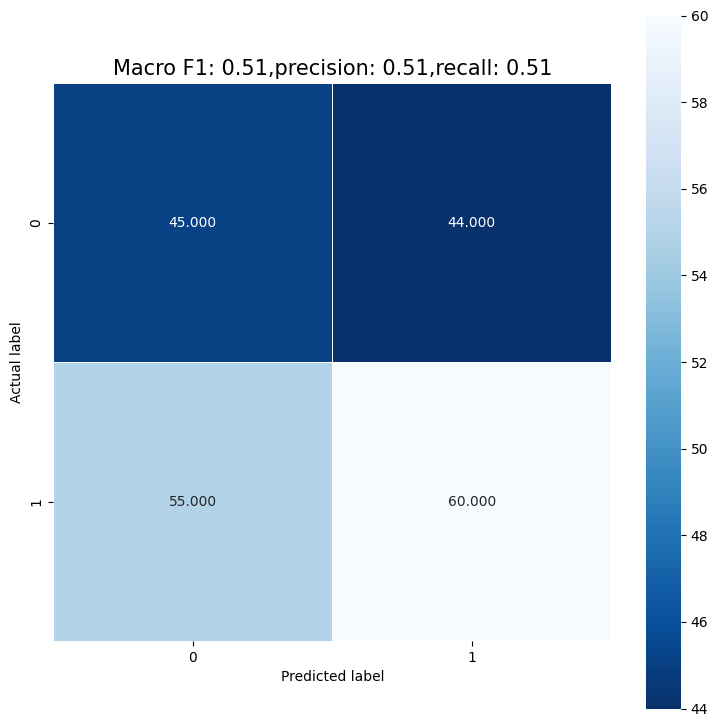

In [ ]:
#confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(cm)

b_score = balanced_accuracy_score(y_val, y_pred)
b_score = round(b_score,4)
print('balanced_accuracy: ' + '{:.4f}'.format(b_score))


#f1 score
#from sklearn.metrics import f1_score
#macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
f1_macro = f1_score(y_val, y_pred, average='macro')
ls_f1 = f1_score(y_val, y_pred, average=None)
precision1 = precision_score(y_val, y_pred, average=None)[1]
recall1 = recall_score(y_val, y_pred, average=None)[1]
precision_macro= precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
print('f1_macro: ' + '{:.4f}'.format(f1_macro))
print('all f1: ' + " ".join("%.4f" % x for x in ls_f1))

#visualize confusion matrix
#import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Macro F1: '+'{:.2f}'.format(f1_macro) + ',precision: {:.2f}'.format(precision_macro)+ ',recall: {:.2f}'.format(recall_macro)
plt.title(all_sample_title, size = 15)

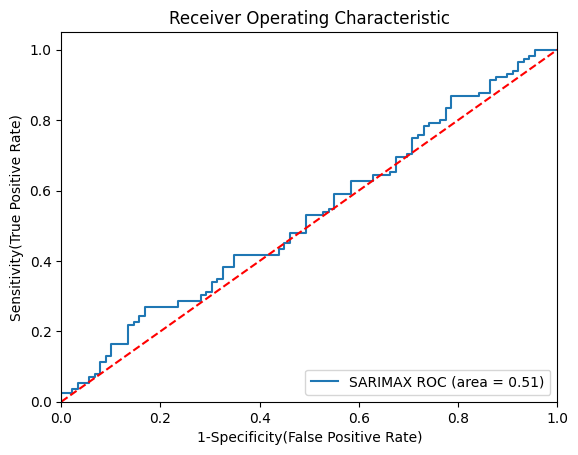

In [ ]:
#from sklearn.metrics import roc_curve
y_proba = proba[-n_forecast:]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
# Calculate Area under the curve to display on the plot
auc = roc_auc_score(y_val,y_pred)
# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SARIMAX', auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

## Deep learning

In [ ]:
file_name = 'df_remove_coll_scaled.csv'
df=pd.read_csv(file_name,index_col = 0)
df.head()

,AA,AC,AF,AG,AJ,AK,AL,AM,AO,AP,...,EG,EH,EI,EJ,M,W,Y,Z,target,bi_target
date,,,,,,,,,,,,,,,,,,,,,
2010-05-11,0.639493,-0.679661,-0.463059,-0.905171,0.676805,-0.542846,1.059852,0.414403,-0.020169,-1.088885,...,1.685483,0.370869,-1.826224,1.932708,0.770817,0.104796,-0.045212,-0.093926,-0.022168,0
2010-05-18,-0.280400,-1.199177,-1.527085,-1.439397,0.676805,2.495230,1.487810,-0.162185,-0.143268,-0.996600,...,1.868164,-0.475042,0.906274,1.347916,0.100422,-0.024703,-1.309273,-0.818270,0.054593,1
2010-05-25,0.026231,-0.419904,-0.596063,-1.795547,0.676805,-1.171272,0.337537,0.549070,-0.028578,-1.263794,...,1.516444,0.027038,0.828261,0.334246,0.686110,0.536460,-0.519234,-0.093926,-0.033822,0
2010-06-01,0.026231,-0.679661,-0.197053,-1.023888,0.676805,-0.958460,0.368796,0.548260,-0.411949,-1.179210,...,1.699614,-0.514248,-1.055752,1.810071,0.731901,0.536460,-0.045212,0.026798,0.031250,1
2010-06-08,-0.280400,-0.679661,-0.862069,-1.201963,0.676805,1.309638,1.280834,0.540841,-0.133370,-1.304944,...,1.240322,-0.888838,0.341905,1.530049,1.041963,1.011290,-0.203219,-0.576822,0.045053,1


In [ ]:
# How many missing data exist
missing_data=pd.DataFrame(df.isnull().sum().reset_index())
#missing_data=pd.DataFrame(df_train.isna().sum().reset_index())

missing_data.columns=["index","missingcount"]
missing_data=missing_data[missing_data["missingcount"]>0]
missing_data['missingper']=(missing_data['missingcount']/df.shape[0])*100


missing_data.set_index('index', inplace = True)
missing_data

,missingcount,missingper
index,,


In [ ]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)
df['time_idx'] = range(0, 0+len(df))

In [ ]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###
def cycle_encode(data, cols):

    for col in cols:

        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [ ]:
df.index = pd.to_datetime(df.index , format = '%Y-%m-%d')
df_external = pd.DataFrame(df.index)
df_external['year'] = df_external.date.dt.year
df_external['month'] = df_external.date.dt.month


df_external['week'] = df_external.date.dt.strftime('%V').astype('int')
df_external = cycle_encode(df_external, ['year','month','week'])
df_external.drop(['year','month','week'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(678, 6)


,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos
date,,,,,,
2010-05-11,-0.040365,0.999185,5.000000e-01,-0.866025,0.776524,-0.630088
2010-05-18,-0.040365,0.999185,5.000000e-01,-0.866025,0.696551,-0.717507
2010-05-25,-0.040365,0.999185,5.000000e-01,-0.866025,0.606800,-0.794854
2010-06-01,-0.040365,0.999185,1.224647e-16,-1.000000,0.508531,-0.861044
2010-06-08,-0.040365,0.999185,1.224647e-16,-1.000000,0.403123,-0.915146


In [ ]:
df_full = pd.concat([df, df_external], axis = 1)
df_full["group_ids"] = 'target'
df_full['bi_target'] = df_full['bi_target'].apply(str)
df_full.head()

,AA,AC,AF,AG,AJ,AK,AL,AM,AO,AP,...,target,bi_target,time_idx,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos,group_ids
date,,,,,,,,,,,,,,,,,,,,,
2010-05-11,0.639493,-0.679661,-0.463059,-0.905171,0.676805,-0.542846,1.059852,0.414403,-0.020169,-1.088885,...,-0.022168,0,0,-0.040365,0.999185,5.000000e-01,-0.866025,0.776524,-0.630088,target
2010-05-18,-0.280400,-1.199177,-1.527085,-1.439397,0.676805,2.495230,1.487810,-0.162185,-0.143268,-0.996600,...,0.054593,1,1,-0.040365,0.999185,5.000000e-01,-0.866025,0.696551,-0.717507,target
2010-05-25,0.026231,-0.419904,-0.596063,-1.795547,0.676805,-1.171272,0.337537,0.549070,-0.028578,-1.263794,...,-0.033822,0,2,-0.040365,0.999185,5.000000e-01,-0.866025,0.606800,-0.794854,target
2010-06-01,0.026231,-0.679661,-0.197053,-1.023888,0.676805,-0.958460,0.368796,0.548260,-0.411949,-1.179210,...,0.031250,1,3,-0.040365,0.999185,1.224647e-16,-1.000000,0.508531,-0.861044,target
2010-06-08,-0.280400,-0.679661,-0.862069,-1.201963,0.676805,1.309638,1.280834,0.540841,-0.133370,-1.304944,...,0.045053,1,4,-0.040365,0.999185,1.224647e-16,-1.000000,0.403123,-0.915146,target


In [ ]:
#Hyperparameters
max_prediction_length = 12
max_encoder_length = 48
training_cutoff = df["time_idx"].max() - max_prediction_length
#training_cutoff = round(len(df_full)*0.8)

training = TimeSeriesDataSet(
    df_full[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="bi_target",
    group_ids=["group_ids"],
    static_categoricals=["group_ids"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=list(df_full.columns.difference(['bi_target','target','group_ids'])),
    time_varying_unknown_reals=['target'],
    #time_varying_unknown_categoricals = ['bi_target'],
    target_normalizer=NaNLabelEncoder(),
    #target_normalizer=EncoderNormalizer(),
    add_relative_time_idx=True,
    add_encoder_length=True,
)

"""
target_normalizer=GroupNormalizer(
        groups=["group_ids"], transformation=None
    ),  # we normalize by group
"""

validation = TimeSeriesDataSet.from_dataset(training, df_full,
                                            predict=True, stop_randomization=True,
                                            min_prediction_length= 1,
                                            min_prediction_idx=training_cutoff + 1)
# create dataloaders for  our model
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
#Baseline model
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
#print(QuantileLoss()(baseline_predictions.output, baseline_predictions.y))
#CrossEntropy()(baseline_predictions.output.float(), baseline_predictions.y[0])
y_true = baseline_predictions.y[0].numpy().flatten()
y_pred = baseline_predictions.output.float().numpy().flatten()
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#print('BCE:',bce(y_true, y_pred).numpy())

criterion = base_metrics.convert_torchmetric_to_pytorch_forecasting_metric(torch.nn.BCEWithLogitsLoss())
print('Baseline BCE loss: ',criterion(baseline_predictions.output.float(),baseline_predictions.y[0].float()))


Baseline BCE loss:  tensor(0.8966)


In [ ]:

y_pred = baseline_predictions.output.numpy().flatten()
y_val = baseline_predictions.y[0].numpy().flatten()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12



In [ ]:
init_params = {'gradient_clip_val': 0.01, 'hidden_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.005}

In [ ]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("clf_logs")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='cpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=init_params['gradient_clip_val'],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=init_params['learning_rate'],
    hidden_size=init_params['hidden_size'],
    attention_head_size=init_params['attention_head_size'],
    dropout=init_params['dropout'],
    hidden_continuous_size=init_params['hidden_continuous_size'],
    output_size=2,
    loss=CrossEntropy(),
    log_interval=10,
    reduce_on_plateau_patience=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 1.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 392   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 25.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved. New best score: 0.713
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.713


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.687
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.687


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.683
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.683


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.680
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.680


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.678
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
#clf_logs/lightning_logs/version_6/checkpoints/epoch=13-step=588.ckpt
#clf_logs/lightning_logs/version_0/checkpoints/epoch=16-step=714.ckpt
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

#Evaluate on Training data
train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

#ls_train_size2 = [y[0].shape for x, y in iter(train_evaluation_dataloader)]

actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)])#.to("cuda")
predictions = best_tft.predict(train_evaluation_dataloader)

clf_logs/lightning_logs/version_0/checkpoints/epoch=16-step=714.ckpt


In [ ]:
"""
#Evaluate on Training data
y_val = actuals.numpy().flatten()
y_pred = predictions.numpy().flatten()
print(classification_report(y_val, y_pred))
"""

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3900
           1       0.81      0.85      0.83      4224

    accuracy                           0.82      8124
   macro avg       0.82      0.82      0.82      8124
weighted avg       0.82      0.82      0.82      8124



In [ ]:
"""
#Evaluate on Training data
y_val = actuals.numpy().flatten()
y_pred = predictions.numpy().flatten()
print(classification_report(y_val, y_pred))
"""

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3900
           1       0.83      0.89      0.86      4224

    accuracy                           0.85      8124
   macro avg       0.85      0.84      0.84      8124
weighted avg       0.85      0.85      0.84      8124



In [ ]:
#Evaluate on Training data
y_val = actuals.numpy().flatten()
y_pred = predictions.numpy().flatten()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      3900
           1       0.79      0.85      0.82      4224

    accuracy                           0.81      8124
   macro avg       0.81      0.81      0.81      8124
weighted avg       0.81      0.81      0.81      8124



Next several cells show a few separate runs on the validation data

In [ ]:
"""
#Evaluate on validation data
val_predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
y_val = val_predictions.y[0].numpy().flatten()
y_pred = val_predictions.output.numpy().flatten()
print(classification_report(y_val, y_pred))
"""

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.25      0.20      0.22         5

    accuracy                           0.42        12
   macro avg       0.38      0.39      0.38        12
weighted avg       0.40      0.42      0.40        12



In [ ]:
"""
#Evaluate on validation data
val_predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
y_val = val_predictions.y[0].numpy().flatten()
y_pred = val_predictions.output.numpy().flatten()
print(classification_report(y_val, y_pred))
"""

              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       0.00      0.00      0.00         5

    accuracy                           0.33        12
   macro avg       0.22      0.29      0.25        12
weighted avg       0.26      0.33      0.29        12



In [ ]:
#Evaluate on validation data
val_predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
y_val = val_predictions.y[0].numpy().flatten()
y_pred = val_predictions.output.numpy().flatten()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.29      0.40      0.33         5

    accuracy                           0.33        12
   macro avg       0.34      0.34      0.33        12
weighted avg       0.35      0.33      0.33        12



In [ ]:
print('Best Model BCE loss: ',criterion(val_predictions.output.float(),val_predictions.y[0].float()))

Best Model BCE loss:  tensor(0.8882)


Comparison of performance in terms of binary cross entropy

> KNN-DTW: 0.7079
> Arima without exog: 0.7413
> Arima with exog: 0.7152
> Baseline: 0.8966
> TFT: 0.8882

TFT suffers from overfitting since the f1 score of the training dataset (around 0.8) is much higer than the one for the validation dataset (around 0.5). \\

KNN-DTW has the best performance but is computationally heavy\\

Arima with exogeneous features also had decent performance on validation dataset and without reasonable computation cost





In [ ]:
#save the model
#!zip  -r init_clf_model.zip clf_logs/lightning_logs/*

Hyperparameter Tuning if time allows

In [ ]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=50),
    reduce_on_plateau_patience=10,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    loss = CrossEntropy()
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-07-17 12:21:27,109] A new study created in memory with name: no-name-e5d208e1-39ed-4b1b-baa7-59209201d4af
[I 2023-07-17 12:44:20,285] Trial 0 finished with value: 0.19027338922023773 and parameters: {'gradient_clip_val': 0.03615255047005619, 'hidden_size': 19, 'dropout': 0.29432375634601315, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.021776610740606883}. Best is trial 0 with value: 0.19027338922023773.
[I 2023-07-17 13:29:06,188] Trial 1 finished with value: 0.19127021729946136 and parameters: {'gradient_clip_val': 0.038739957366012365, 'hidden_size': 108, 'dropout': 0.2847141344195122, 'hidden_continuous_size': 28, 'attention_head_size': 1, 'learning_rate': 0.004648349888613686}. Best is trial 0 with value: 0.19027338922023773.
[I 2023-07-17 13:46:40,912] Trial 2 finished with value: 0.4108145534992218 and parameters: {'gradient_clip_val': 0.3225828991734484, 'hidden_size': 36, 'dropout': 0.2999932808677477, 'hidden_continuous_size': 32, 'attenti